## Neural Processes

This notebook demonstrates the implementation of the Neural Processes. The model is trained to predict the distribution of the target function given a few examples of the function. In this notebook we will attempt to reconstruct an entire image given a few pixels of the image. 

$$Model(\{x_c, y_c\}_{c=1}^n, \{x_t\}_{t=1}^m) \rightarrow \{y_t\}_{t=1}^m$$ 

$\{x_c, y_c\}_{c=1}^n$ are the context points where $x_i$ are the input features and $y_i$ are the labels.

$\{x_t\}_{t=1}^m$ are the target features where we want to predict the label values $y_j$.

![Neural Processes Block Diagram](../../images/blogs/Neural_Process/NP_1.png)


<!-- ![Neural Processes Diagram](../../images/blogs/Neural_Process/NP_2.png) -->

The model is composed of two neural networks: the encoder and the decoder. The encoder takes the context set as the input and encodes them into a fixed-size representation. The decoder takes the representation and the target features and predicts the pixel labels of the given target features.

## Image Reconstruction using Neural Processes

We wish to reconstruct an entire image given a few pixels of the image. The few pixels of the image are the context points and the entire image is the target function.

So for our case, the pixel locations $x = (x^1, x^2)$ and the pixel intensity values $y = Img(x^1, x^2)$ or just $I$ denoting intensity for simplicity.

$$Model(\{(x^1_c, x^2_c, I_c)\}_{c=1}^n, \{(x^1_t, x^2_t)\}_{t=1}^m) \rightarrow \{I_t\}_{t=1}^m$$

For  model training we will randomly sample a fixed number of pixel locations from the image and use them as context points. The model is trained to predict the pixel intensity value at all the other pixel locations. At the time of prediction, We will provide few pixel locations and the model will predict the pixel intensity values for all the pixel locations in the image.

![Elaborate Neural Processes Block Diagram](../../images/blogs/Neural_Process/NP_3.png)

In [53]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

from torchsummary import summary

from tqdm import tqdm

### Generating Tasks from the MNIST Dataset

#### Downloading the MNIST Dataset

We will be using the MNIST dataset for this task. The MNIST dataset consists of 28x28 grayscale images of handwritten digits (0-9). We will download the dataset using the `torchvision` library. We will convert the images to tensors and no further preprocessing is being performed on the images.

In [54]:
# Downlaoding the MNIST dataset
train_data = MNIST(root='./data', train=True, download=True, transform=ToTensor())
test_data = MNIST(root='./data', train=False, download=True, transform= ToTensor())

#### Creating Context and Target sets

We will sample a random number of pixel coordinates $(x^1, x^2)$ and the pixel intensity values $I$ for these coordinates. These coordinates and pixel intensity values will be used as context points. The Test set will contain all the pixel coordinates and Intensities of the image. The model will predict the pixel intensity values for all the pixel coordinates in the image.

In [63]:
def get_Context_Target_Sets(images_data, no_context_points,Image_shape):

    m,n = Image_shape

    # All possible coordinates in the image. Size of MNIST image is 28x28
    All_corrdinates = np.array([(i,j) for i in range(m) for j in range(n)])

    # Iterate over the dataset and create the context set and target set
    task_set = []
    for i in tqdm(range(len(images_data))):

        # Images in the dataset are of shape (1, 28, 28). We need to remove the channel dimension to get the shape (28, 28)
        image, _ = images_data[i]
        image = image.squeeze().numpy()     # un-squeeze the image to remove the channel dimension

        # Sample random context points indices
        context_idx = np.random.choice(range(len(All_corrdinates)), no_context_points, replace=False)

        # Get the context points and their corresponding pixel values from the generated context indices
        context_points = All_corrdinates[context_idx]
        context_pixels = image[context_points[:,0], context_points[:,1]]

        # Concatenate the context points and their corresponding pixel values
        context_set = np.concatenate([context_points, context_pixels.reshape(-1,1)], axis=-1).astype(np.float32)

        # For training the model, we need to predict the pixel values for all the pixels in the image
        target_points = All_corrdinates
        target_pixels = image[target_points[:,0], target_points[:,1]]

        # Concatenate the target points and their corresponding pixel values
        target_set = np.concatenate([target_points, target_pixels.reshape(-1,1)], axis=-1).astype(np.float32)

        # Append the context set and target set to the train_set
        task_set.append((context_set, target_set))

    return task_set

In [64]:
train_set = get_Context_Target_Sets(images_data=train_data, no_context_points=200, Image_shape=(28,28))
train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)

for context_pairs, target_pairs in train_dataloader:
    print(context_pairs.shape, target_pairs.shape)
    break

100%|██████████| 60000/60000 [00:04<00:00, 12578.65it/s]


torch.Size([32, 200, 3]) torch.Size([32, 784, 3])


In [71]:
test_set = get_Context_Target_Sets(images_data=test_data, no_context_points=200, Image_shape=(28,28))
test_dataloader = DataLoader(test_set, batch_size=32, shuffle=True)

for context_pairs, target_pairs in test_dataloader:
    print(context_pairs.shape, target_pairs.shape)
    break

100%|██████████| 10000/10000 [00:00<00:00, 11855.53it/s]

torch.Size([32, 200, 3]) torch.Size([32, 784, 3])


### Intializing the Model Class

#### Encoder and Decoder Networks
Our Model class will contain the Encoder and Decoder networks. The Encoder network will take the context points and encode them into a fixed-size representation. The Decoder network will take the representation and the pixel coordinates and predict the pixel intensity value of the given coordinate.

#### Training Method
Method to train the model. The model is trained to predict the pixel intensity values of the target pixel coordinates given the context points. The loss function is the Mean Squared Error loss between the predicted pixel intensity values and the actual pixel intensity values. 

#### Testing Method
Method to test the model. The model is tested on the test set. The model is provided with the context points and the model predicts the pixel intensity values of the target pixel coordinates. The Mean Squared Error loss is calculated between the predicted pixel intensity values and the actual pixel intensity values.




In [67]:
class Neural_Procss_Model(nn.Module):
    """
    Neural Process Model has two parts: encoder and decoder

    Encoder takes in the context pairs (X1_c, X2_c, PixelIntensity) and encode them into a latent representation

    Decoder takes in the latent representation and the target pairs (X1_t, X2_t) and output the predicted target pairs
    """
    def __init__(self,device):
        super(Neural_Procss_Model, self).__init__()

        if device == 'cuda':
            if torch.cuda.is_available():
                device = torch.device('cuda')
        
        if device == 'mps':
            device = torch.device('mps')

        self.device = device

        # Encoder takes in the context pairs (X1c,X2c,PixelIntensity) and encode them into a latent representation
        self.encoder = nn.Sequential(
            nn.Linear(3,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,256),
        )

        # Decoder takes in the latent representation and the target pairs and output the predicted target pairs
        self.decoder = nn.Sequential(
            nn.Linear(256+2,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,1)
        )

    def forward(self, context_pairs, target_pairs):
        """
        Forward pass of the Neural Process Model. 
        
        It takes in the context cordinate pairs (X1_c, X2_c, PixelIntensity) and target cordinate pairs (X1_t, X2_t, PixelIntensity) and output the predicted target pixel intensity for the target cordinate pairs

        Parameters:
        context_pairs: torch.Tensor of shape (batch_size, num_context_pairs, 3)
        target_pairs: torch.Tensor of shape (batch_size, num_target_pairs, 2)

        Returns:
        predicted_target_Pixel Intensity: torch.Tensor of shape (batch_size, num_target_pairs, 1)
        """
        
        # Encode the context pairs into a latent representation
        latent_representation = self.encoder(context_pairs)

        # Average the latent representation
        latent_representation = torch.mean(latent_representation,dim=1)

        # Repeat the latent representation for each target pair
        latent_representation = latent_representation.unsqueeze(1).repeat(1,target_pairs.size(1),1)

        # Concatenate the latent representation with the target pixel locations
        target_pixel_locations = target_pairs[:,:,:2]
        target = torch.cat([latent_representation,target_pixel_locations],dim=-1)

        # Decode the target pairs to obtain the predicted target pixel intensity
        predicted_target_pixel_intensity = self.decoder(target)

        return predicted_target_pixel_intensity
    

    def train(self, train_dataloader, num_epochs=100, optim = torch.optim.Adam, lr=3e-4, criterion = nn.MSELoss(),verbose=True):
        """
        Train the Neural Process Model

        Parameters:
        train_dataloader: DataLoader object for the training data
        num_epochs: int, number of epochs to train the model
        optimer: str, optimer to use for training the model
        lr: float, learning rate for the optimer
        criterion: loss function to use for training the model
        """

        device = self.device

        # Move the model to the device
        self.to(device)

        # Initialize the optimizer
        optimizer = optim(self.parameters(), lr=lr)

        for epoch in range(num_epochs):
            for i, (context_pairs, target_pairs) in enumerate(train_dataloader):
                context_pairs = context_pairs.to(device)
                target_pairs = target_pairs.to(device)

                # Zero the gradients
                optimizer.zero_grad()

                # Forward pass
                predicted_target_pixel_intensity = self(context_pairs, target_pairs)

                # Calculate the loss
                loss = criterion(predicted_target_pixel_intensity.reshape(-1,1), target_pairs[:,:,2].reshape(-1,1))

                # Backward pass
                loss.backward()

                # Update the weights
                optimizer.step()

            if verbose:
                print("Epoch: {}/{} Loss: {:.5f}".format(epoch+1,num_epochs,loss.item()))



    def test(self, test_dataloader, criterion = nn.MSELoss()):
        """
        Test the Neural Process Model

        Parameters:
        test_dataloader: DataLoader object for the test data
        """

        device = self.device
    
        # Move the model to the device
        self.to(device)

        # Initialize the loss
        test_loss = 0

        with torch.no_grad():
            for i, (context_pairs, target_pairs) in enumerate(test_dataloader):
                context_pairs = context_pairs.to(device)
                target_pairs = target_pairs.to(device)

                # Forward pass
                predicted_target_pixel_intensity = self(context_pairs, target_pairs)

                # Calculate the loss
                loss = criterion(predicted_target_pixel_intensity.reshape(-1,1), target_pairs[:,:,2].reshape(-1,1))

                test_loss += loss.item()

        print(f'Test Loss: {test_loss/len(test_dataloader)}')

        

### Training the model

In [68]:
# Set the device. If cuda is available, use cuda. 
if torch.cuda.is_available():
    device = torch.device('cuda')

# If mps is available, use mps. 
elif torch.mps.is_available():
    device = torch.device('mps')

# Else use cpu
else:
    device = torch.device('cpu')

print("Device in use: ", device)

Device in use:  mps


In [29]:
model = Neural_Procss_Model(device=device)

# model.to('cuda')

model.train(train_dataloader, num_epochs=30)

Epoch: 1/30 Loss: 0.06018
Epoch: 2/30 Loss: 0.06170
Epoch: 3/30 Loss: 0.05950
Epoch: 4/30 Loss: 0.06060
Epoch: 5/30 Loss: 0.05958
Epoch: 6/30 Loss: 0.06148
Epoch: 7/30 Loss: 0.05642
Epoch: 8/30 Loss: 0.05425
Epoch: 9/30 Loss: 0.05090
Epoch: 10/30 Loss: 0.04823
Epoch: 11/30 Loss: 0.04689
Epoch: 12/30 Loss: 0.04165
Epoch: 13/30 Loss: 0.04482
Epoch: 14/30 Loss: 0.04253
Epoch: 15/30 Loss: 0.03567
Epoch: 16/30 Loss: 0.04409
Epoch: 17/30 Loss: 0.03556
Epoch: 18/30 Loss: 0.03798
Epoch: 19/30 Loss: 0.03793
Epoch: 20/30 Loss: 0.03933
Epoch: 21/30 Loss: 0.03644
Epoch: 22/30 Loss: 0.03336
Epoch: 23/30 Loss: 0.03567
Epoch: 24/30 Loss: 0.03594
Epoch: 25/30 Loss: 0.03620
Epoch: 26/30 Loss: 0.03798
Epoch: 27/30 Loss: 0.03487
Epoch: 28/30 Loss: 0.03350
Epoch: 29/30 Loss: 0.03534
Epoch: 30/30 Loss: 0.03392


In [69]:
model.test(test_dataloader)

Test Loss: 0.03589645992762174


### Testing the model

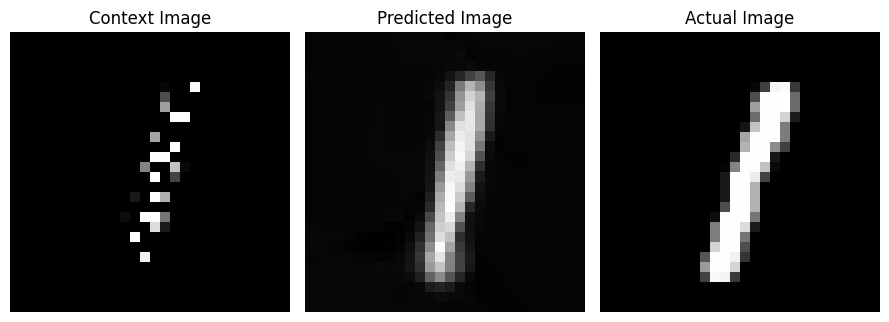

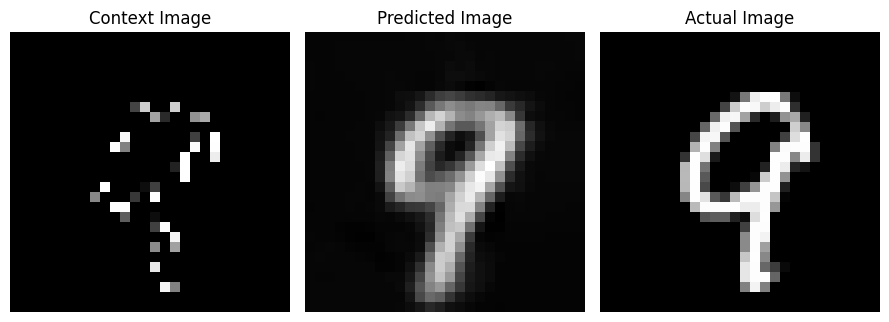

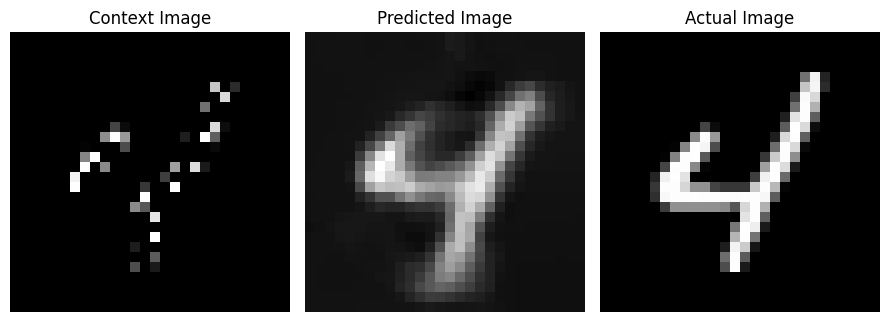

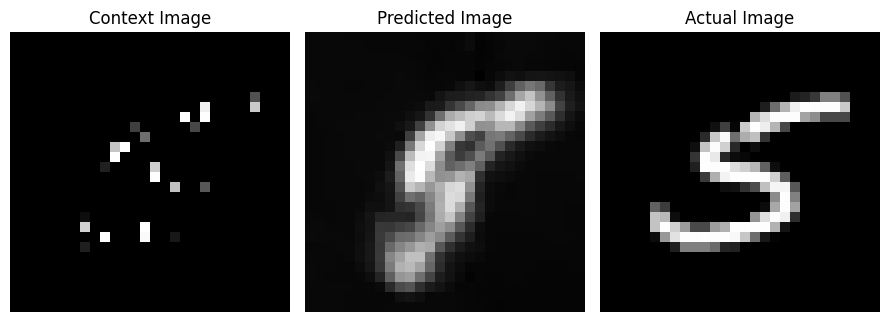

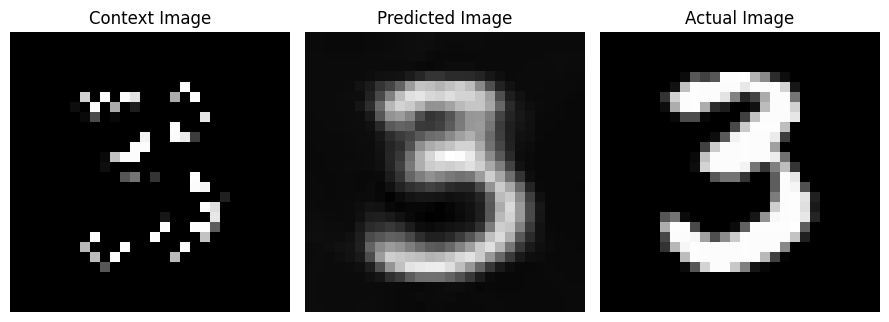

In [72]:
for context_pairs, target_pairs in test_dataloader:
    context_pairs = context_pairs.to(device)
    target_pairs = target_pairs.to(device)

    predicted_target_pixel_intensity = model(context_pairs, target_pairs)

    for i in range(5):
        predicted_pixel = predicted_target_pixel_intensity[i].detach().cpu().numpy()
        predicted_image = predicted_pixel.reshape(28,28)

        actual_pixel = target_pairs[i][:,2].detach().cpu().numpy()
        actual_image = actual_pixel.reshape(28,28)

        context_image = np.zeros((28,28))
        context_pixel_locations = context_pairs[i][:,:2].detach().cpu().numpy().astype(int) 
        context_image[context_pixel_locations[:,0], context_pixel_locations[:,1]] = context_pairs[i][:,2].detach().cpu().numpy()

        plt.figure(figsize=(9,4))

        plt.subplot(1,3,1)
        plt.imshow(context_image, cmap='gray')
        plt.axis('off')
        plt.title('Context Image')
        
        plt.subplot(1,3,2)
        plt.imshow(predicted_image, cmap='gray')
        plt.axis('off')
        plt.title('Predicted Image')

        plt.subplot(1,3,3)
        plt.imshow(actual_image, cmap='gray')
        plt.axis('off')
        plt.title('Actual Image')
        
        plt.tight_layout()
        plt.show()

    break
